In [1]:
import os
os.chdir("../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(3)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point_gaussian, quantile_s2p
import scipy.stats as st
# from mapie.metrics import regression_coverage_score
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

2024-04-15 13:33:02.871292: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
def data_preprocess(only_positive=False):
    data = pd.read_csv(
        '/home/haikoo.khandor/haikoo/Final_ConformalNILM/normal/notebooks/deploy/Energy_Data.csv')
    appliances = [
        'LivingRoomAC (kWatts)', 'Fridge+OTG (kWatts)']
    required_cols = ['Time Bucket (Asia/Calcutta)', 'Mains (kWatts)']
    data_new = data[(appliances+required_cols)]
    data_new = data_new.dropna()
    if only_positive:
        numeric_cols = data_new.select_dtypes(include='number').columns
        for col in numeric_cols:
            data_new = data_new.loc[(data_new[col] >= 0)
                                    | data_new[col].isna()]
        data_aggregated = data_new.copy()
    else:
        data_aggregated = data_new.copy()
    return data_aggregated

In [5]:
def dataloader(appliance, train, start_date, end_date, n):
    x_train = []
    y_train = []
    n = n
    units_to_pad = n//2
    start_date = start_date
    end_date = end_date
    train_df = train[[
        "Time Bucket (Asia/Calcutta)", "Mains (kWatts)", appliance]]
    train_df = train_df[(train_df["Time Bucket (Asia/Calcutta)"] > start_date)
                        & (train_df["Time Bucket (Asia/Calcutta)"] < end_date)]
    x = train_df["Mains (kWatts)"].values*1000
    y_train = train_df[appliance].values*1000
    x_train = np.pad(np.array(x), (units_to_pad, units_to_pad),
                     'constant', constant_values=(0, 0))
    x_train = np.array([np.array(x_train[i: i + n])
                       for i in range(len(np.array(x_train)) - n + 1)])
    x_train = np.array(x_train)
    y_train = np.array(y_train).reshape(-1, 1)
    return x_train, y_train

In [87]:
def find_coverage_calib(y, y_upper_all, y_lower_all, ci, flag=False):
    q_hats = []
    times = []
    E_is = []
    random_seed = 42
    np.random.seed(random_seed)
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_upper_all[i]
            lower = y_lower_all[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                q_hats.append(0)
                continue
            initial_upper = y_upper_all[i]
            initial_lower = y_lower_all[i]
            upper_err = np.array(y).reshape(-1) - \
                np.array(initial_upper).reshape(-1)
            lower_err = np.array(initial_lower).reshape(-1) - \
                np.array(y).reshape(-1)
            E_i = np.max(np.vstack((lower_err, upper_err)), axis=0)
            E_i = E_i + np.random.normal(0, 0.003, len(E_i))
            E_is.append(E_i)
            q_level = np.ceil((len(y)+1)*ci[i])/len(y)
            q_hat = np.quantile(E_i, q_level, method='higher')
            q_hats.append(q_hat)
            upper = initial_upper + q_hat
            lower = initial_lower - q_hat
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats, times, E_is

In [7]:
def find_coverage_train_test(y, y_upper_all, y_lower_all, ci, q_hats, flag=False):
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_upper_all[i]
            lower = y_lower_all[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                continue
            upper = y_upper_all[i] + q_hats[i]
            lower = y_lower_all[i] - q_hats[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats

In [8]:
def calib_errors(ci, coverages):
    ece = 0.0
    ace = 0.0
    for i in range(len(ci)):
        ace += abs(ci[i]-coverages[i])
    ece = ace/len(ci)
    return ace, ece

In [9]:
def get_trained_model(ci, x_train, y_train):
    alpha = 1 - ci
    lower_params_all = []
    upper_params_all = []
    lower_model_all = []
    upper_model_all = []
    for i in range(len(ci)):
        # define model
        lower_model = quantile_s2p.QuantileRegression(alpha=alpha[i]/2)
        upper_model = quantile_s2p.QuantileRegression(alpha=1 - alpha[i]/2)

        # initialize model and train
        lower_params = lower_model.init(jax.random.PRNGKey(0), x_train, True)
        lower_params, lower_losses = fit(lower_model, lower_params, x_train, y_train, False,
                                         batch_size=1024, learning_rate=0.0001, epochs=50)
        upper_params = upper_model.init(jax.random.PRNGKey(0), x_train, True)
        upper_params, upper_losses = fit(upper_model, upper_params, x_train, y_train, False,
                                         batch_size=1024, learning_rate=0.0001, epochs=50)
        lower_model_all.append(lower_model)
        upper_model_all.append(upper_model)
        lower_params_all.append(lower_params)
        upper_params_all.append(upper_params)
    return lower_params_all, upper_params_all, lower_model_all, upper_model_all

In [10]:
def get_all(ci, x, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler):
    lower_all = []
    upper_all = []
    for i in range(len(ci)):
        # get predictions x = {cal, test}
        y_hat_lower = lower_model_all[i].apply(lower_params_all[i], x, False, rngs={
            "dropout": jax.random.PRNGKey(0)})
        y_hat_upper = upper_model_all[i].apply(upper_params_all[i], x, False, rngs={
            "dropout": jax.random.PRNGKey(0)})
        mean_upper = scaler.inverse_transform(y_hat_upper)
        mean_lower = scaler.inverse_transform(y_hat_lower)
        lower_all.append(mean_lower)
        upper_all.append(mean_upper)
    return lower_all, upper_all

In [11]:
data_aggregated = data_preprocess(only_positive=True)
appliances = [
    'LivingRoomAC (kWatts)', 'Fridge+OTG (kWatts)']
appliance = appliances[1]
n = 99

In [12]:
x_train, y_train = dataloader(
    appliance, data_aggregated, "07/01/2022 00:00:00", "07/08/2022 23:59:00", n)
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
y_train = scaler_y.fit_transform(y_train)
x_train = jnp.array(x_train).reshape(x_train.shape[0], n, 1)
y_train = jnp.array(y_train)
x_train, x_cal, y_train, y_cal = train_test_split(
    x_train, y_train, test_size=0.25, random_state=42)

In [13]:
x_test, y_test = dataloader(
    appliance, data_aggregated, "07/09/2022 00:00:00", "07/10/2022 23:59:00", n)
x_test = scaler_x.transform(x_test)
x_test = jnp.array(x_test).reshape(x_test.shape[0], n, 1)
y_test = jnp.array(y_test)

In [14]:
y_true_cal = scaler_y.inverse_transform(y_cal)
y_train_scaled = scaler_y.inverse_transform(y_train)

In [15]:
ci = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

In [16]:
lower_params_all, upper_params_all, lower_model_all, upper_model_all = get_trained_model(
    ci, x_train, y_train)

In [17]:
lower_train_all, upper_train_all = get_all(
    ci, x_train, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler_y)
lower_test_all, upper_test_all = get_all(
    ci, x_test, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler_y)
lower_cal_all, upper_cal_all = get_all(
    ci, x_cal, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler_y)

In [18]:
initial_coverages_cal, _, _, _ = find_coverage_calib(
    y_true_cal, upper_cal_all, lower_cal_all, ci)
initial_coverages_train, _ = find_coverage_train_test(
    y_train_scaled, upper_train_all, lower_train_all, ci, [])
initial_coverages_test, _ = find_coverage_train_test(
    y_test, upper_test_all, lower_test_all, ci, [])

In [19]:
initial_coverages_cal

array([0.        , 0.10409438, 0.17071478, 0.2463567 , 0.33657183,
       0.40631506, 0.51977793, 0.62977099, 0.67244969, 0.82824427,
       1.        ])

In [20]:
initial_coverages_test

array([0.        , 0.0705106 , 0.14935742, 0.2254255 , 0.28100035,
       0.36470997, 0.46682876, 0.62486976, 0.66689825, 0.80027789,
       0.99930537])

In [21]:
initial_coverages_train

array([0.        , 0.10968414, 0.20189749, 0.26911952, 0.38377878,
       0.47113271, 0.58313086, 0.68228624, 0.70762467, 0.86370473,
       1.        ])

In [88]:
flag = True
final_coverages_cal, q_hats, times, Errors_all_cal = find_coverage_calib(
    y_true_cal, upper_cal_all, lower_cal_all, ci, flag=flag)
final_coverages_train, q_hats = find_coverage_train_test(
    y_train_scaled, upper_train_all, lower_train_all, ci, q_hats, flag=flag)
final_coverages_test, q_hats = find_coverage_train_test(
    y_test, upper_test_all, lower_test_all, ci, q_hats, flag=flag)

In [89]:
ace_init_cal, ece_init_cal = calib_errors(ci, initial_coverages_cal)
ace_fin_cal, ece_fin_cal = calib_errors(ci, final_coverages_cal)
print('Calibration:')
print(f'Initial ace error is {ace_init_cal} and ece error is {ece_init_cal}')
print(f'Final ace error is {ace_fin_cal} and ece error is {ece_fin_cal}')

Calibration:
Initial ace error is 0.5938931297709924 and ece error is 0.053990284524635675
Final ace error is 0.0048577376821650475 and ece error is 0.0004416125165604589


In [90]:
ace_init_train, ece_init_train = calib_errors(ci, initial_coverages_train)
ace_fin_train, ece_fin_train = calib_errors(ci, final_coverages_train)
print('Train:')
print(
    f'Initial ace error is {ace_init_train} and ece error is {ece_init_train}')
print(f'Final ace error is {ace_fin_train} and ece error is {ece_fin_train}')

Train:
Initial ace error is 0.25080411894018284 and ece error is 0.02280037444910753
Final ace error is 0.42641443943075313 and ece error is 0.03876494903915938


In [91]:
ace_init_test, ece_init_test = calib_errors(ci, initial_coverages_test)
ace_fin_test, ece_fin_test = calib_errors(ci, final_coverages_test)
print('Test:')
print(f'Initial ace error is {ace_init_test} and ece error is {ece_init_test}')
print(f'Final ace error is {ace_fin_test} and ece error is {ece_fin_test}')

Test:
Initial ace error is 0.8508161306381226 and ece error is 0.07734692096710205
Final ace error is 0.3537685200572014 and ece error is 0.03216077455065467


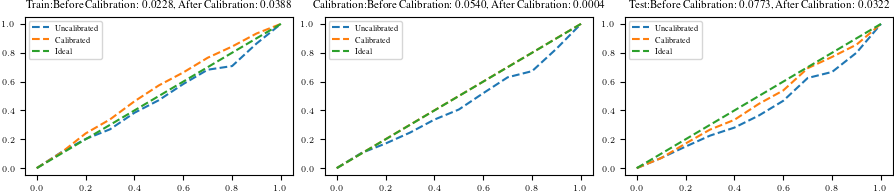

In [92]:
# Train
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (9, 2)})
plt.subplot(1, 3, 1)
plt.plot(ci, initial_coverages_train, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Train:Before Calibration: {"{:.4f}".format(ece_init_train)}, After Calibration: {"{:.4f}".format(ece_fin_train)}')
plt.legend()

# Calibration
plt.subplot(1, 3, 2)
plt.plot(ci, initial_coverages_cal, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Calibration:Before Calibration: {"{:.4f}".format(ece_init_cal)}, After Calibration: {"{:.4f}".format(ece_fin_cal)}')
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.plot(ci, initial_coverages_test, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Test:Before Calibration: {"{:.4f}".format(ece_init_test)}, After Calibration: {"{:.4f}".format(ece_fin_test)}')
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Hetero_Conformal_Conformal.pdf')